In [ ]:
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import  DataLoader
import random
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F

from paths import PRJ_DIR, IMAGENET_DIR, IMAGENET_VAL_DIR, IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

IMAGENET_DIR = IMAGENET_TRAIN_DIR
IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
transform = transforms.Compose([
    transforms.Resize(256, interpolation=Image.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
])
SEED = 1
EPS = 1e-8

DINO_MODEL = "dinov2_vitb14_reg"
    


def eval(dino, dataloader, num_layers, max_samples):
    # Setup
    dino = dino.eval().cuda()

    cosines = torch.zeros(num_layers, num_layers)
    mses = torch.zeros(num_layers, num_layers)
    norms = torch.zeros(num_layers)
    
    num_samples = 0
    with torch.no_grad():  
        for batch in tqdm(dataloader, total=len(dataloader)):
            x = batch[0].cuda()
            num_samples += x.shape[0]

            # Get dino activations
            a = dino._get_intermediate_layers_not_chunked(x, list(range(num_layers)))
            a = torch.stack(a, dim=0) # L x B x N x D
            a1 = a.unsqueeze(0)
            a2 = a.unsqueeze(1)

            # Calculate
            mse = (a1 - a2).square().mean((3, 4)).sum(2)
            cosine = (1.0 - torch.clamp(nn.functional.cosine_similarity(a1, a2, dim=4, eps=EPS), min=-1.0, max=1.0)).mean(3).sum(2)
            mses += mse.cpu()
            cosines += cosine.cpu()

            # Evaluate norms
            norms += torch.linalg.norm(a, ord=2, dim=3).mean(2).sum(1).cpu()
            
            if num_samples >= max_samples:
                break

    cosines = cosines / num_samples
    mses = mses / num_samples
    norms = norms / num_samples
                    
    return cosines.numpy(), mses.numpy(), norms.numpy()


def load_dino(dino_model, device='cpu'):
    return torch.hub.load('facebookresearch/dinov2', dino_model).eval().to(device)


def set_random_seed(seed):
    """function sets the seed value
    Args:
        seed (int): seed value
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def layer_iter_heatmap(results, mask=None, figsize=(10, 10), cmap='viridis', vmin=0, vmax=1.0, fmt="0.3f", annot_kws={"size": 20}):
    #results = (results - np.min(results)) / (np.max(results) - np.min(results)) # normalize to [0, 1]
    layers1 = results.shape[0] # layers 0 to 11 (possible, inclusive)
    layers2 = results.shape[1] # iters 0 to 11 (possible, inclusive)
    # Create DataFrame with custom row and column labels
    row_labels = [f"{i}" for i in range(layers1)] # layer 0 to 10, inclusive
    col_labels = [f"{i}" for i in range(layers2)] # 1 to num_iters, inclusive
    df = pd.DataFrame(results, index=row_labels, columns=col_labels)
    if mask is None:
        mask = np.zeros_like(df, dtype=bool)
    elif mask == 'diag':
        mask = np.eye(df.shape[0], df.shape[1], dtype=bool)
    elif mask == 'tril':
        mask = np.tril(np.ones_like(df, dtype=bool), k=0)            
    # Plot the heatmap
    fig = plt.figure(figsize=figsize)
    sns.heatmap(df, mask=mask, annot=True, fmt=fmt, cmap=cmap, vmin=vmin, vmax=vmax, annot_kws=annot_kws)
    # Label axes
    plt.xlabel("Layer")
    plt.ylabel("Layer")
    fig.tight_layout()
    return fig 

def stable_rank(mat: torch.Tensor) -> torch.Tensor:
    """
    Compute the stable rank of a 2-D matrix (or of the last two
    dims of an n-D tensor) using exact SVD.

    Args
    ----
    mat : Tensor
        Shape (..., m, n) – anything ≥ 2-D works.

    Returns
    -------
    Tensor
        Shape (...) – one stable-rank per leading index.
    """
    mat = torch.from_numpy(mat) if isinstance(mat, np.ndarray) else mat
    fro2 = torch.linalg.norm(mat, ord='fro') ** 2              # (...,)
    sigma1 = torch.linalg.svdvals(mat)[..., 0]                 # (...,)
    return fro2 / (sigma1 ** 2 + 1e-12)      # ε avoids /0 if A = 0

def blockiness_var_explained(A, K_max=10, penalty="bic"):
    """
    Parameters
    ----------
    A : (n, n) array_like
        Square matrix (need not be symmetric).
    K_max : int, optional
        Maximum number of contiguous blocks to consider.  Default 10
        (or n if n < 10).
    penalty : {"bic", "aic", None}
        Criterion for selecting the best K.  If None, just returns the
        score for every K = 1 .. K_max.

    Returns
    -------
    B_seg             : float
        1 - SSE_best / SST  (in [0, 1]).
    K_best            : int
        Number of blocks chosen by the information criterion.
    scores_for_K      : np.ndarray, shape (K_max,)
        Variance-explained for every K.
    """

    A = np.asarray(A)
    assert A.ndim == 2 and A.shape[0] == A.shape[1], "A must be square"
    n = A.shape[0]
    K_max = min(K_max, n)

    # --- total variance (denominator) ---
    SST = np.square(A - A.mean()).sum()

    # --- pre-compute error for every contiguous block [i, j] ---
    SSE_block = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            block = A[i : j + 1, i : j + 1]
            m      = block.size
            s      = block.sum()
            ss     = np.square(block).sum()
            SSE_block[i, j] = ss - s ** 2 / m     # unbiased SSE

    # --- dynamic programming: dp[k, j] = min SSE for first j rows with k blocks ---
    dp   = np.full((K_max + 1, n + 1), np.inf)
    dp[0, 0] = 0.0
    for k in range(1, K_max + 1):
        for j in range(1, n + 1):
            # try ending the k-th block at row/col j-1
            best = np.inf
            for i in range(k - 1, j):
                candidate = dp[k - 1, i] + SSE_block[i, j - 1]
                if candidate < best:
                    best = candidate
            dp[k, j] = best

    # --- translate into "variance explained'’ for each K ---
    scores = 1.0 - dp[1:, n] / SST        # K = 1..K_max

    if penalty is None:
        return scores, None, scores

    # --- pick K via information criterion ---
    n_elem = n * n
    if penalty.lower() == "bic":
        crit = n_elem * np.log(dp[1:, n] / n_elem) + np.arange(1, K_max + 1) * np.log(n_elem)
    elif penalty.lower() == "aic":
        crit = n_elem * np.log(dp[1:, n] / n_elem) + 2 * np.arange(1, K_max + 1)
    else:
        raise ValueError("penalty must be 'bic', 'aic', or None")

    K_best = np.argmin(crit) + 1
    return float(scores[K_best - 1]), int(K_best), scores

def plot_norms(norms):
    fig = plt.figure()
    plt.plot(norms, marker='o'  , linestyle='-', color='blue')
    plt.title('Layer Norms')
    plt.xlabel('Layer')
    plt.ylabel('Norm')
    plt.xticks(ticks=range(len(norms)), labels=[f'Layer {i}' for i in range(len(norms))])
    plt.tight_layout()
    plt.show()

# DINOv2

In [2]:
# Setup
set_random_seed(SEED)
batch_size = 32
valset = datasets.ImageFolder(root=IMAGENET_VAL_DIR, transform=transform)
val_loader = DataLoader(
    valset, batch_size=batch_size, shuffle=True,
    num_workers=4, pin_memory=True, persistent_workers=False, prefetch_factor=20
)
dino = load_dino(DINO_MODEL, device="cuda")

Using cache found in /n/home01/mjacobs/.cache/torch/hub/facebookresearch_dinov2_main
/n/home01/mjacobs/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/n/home01/mjacobs/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/n/home01/mjacobs/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [3]:
def eval_dinov2(dino, dataloader, num_layers, max_samples):
    # Setup
    dino = dino.eval().cuda()

    cosines = torch.zeros(num_layers, num_layers)
    mses = torch.zeros(num_layers, num_layers)
    norms = torch.zeros(num_layers)
    
    num_samples = 0
    with torch.no_grad():  
        for batch in tqdm(dataloader, total=len(dataloader)):
            x = batch[0].cuda()
            num_samples += x.shape[0]

            # Get dino activations
            a = dino._get_intermediate_layers_not_chunked(x, list(range(num_layers)))
            a = torch.stack(a, dim=0) # L x B x N x D
            a_cls = a[:,:,0:1]
            a_patch = a[:,:,5:]
            a = torch.cat((a_cls, a_patch.mean(dim=2, keepdim=True)), dim=2)  # Concatenate cls and patch activations
            a1 = a.unsqueeze(0)
            a2 = a.unsqueeze(1)

            # Calculate
            mse = (a1 - a2).square().mean((3, 4)).sum(2)
            cosine = (1.0 - torch.clamp(nn.functional.cosine_similarity(a1, a2, dim=4, eps=EPS), min=-1.0, max=1.0)).mean(3).sum(2)
            mses += mse.cpu()
            cosines += cosine.cpu()

            # Evaluate norms
            norms += torch.linalg.norm(a, ord=2, dim=3).mean(2).sum(1).cpu()
            
            #if num_samples >= max_samples:
            #    break

    cosines = cosines / num_samples
    mses = mses / num_samples
    norms = norms / num_samples
                    
    return cosines.numpy(), mses.numpy(), norms.numpy()

In [4]:
import numpy as np
from itertools import product

# ---------------------------------------------------------------------
# 1)  MAX-CUT SOLVERS
# ---------------------------------------------------------------------
def _cut_weight(W, side):
    """
    Return total weight of edges crossing the cut defined by Boolean mask `side`.
    side[i] = False  ⇔  vertex i in S
    side[i] = True   ⇔  vertex i in T
    """
    # xor outer product → True where vertices reside on opposite sides
    diff = np.logical_xor.outer(side, side)
    return W[diff].sum() / 2          # each edge counted twice in symmetric W


def max_cut_bruteforce(W):
    """
    Exact max-cut via exhaustive search.  First vertex is pinned to 0 to
    avoid the (S,T) ≡ (T,S) symmetry ⇒ 2^(n-1) candidate cuts.
    Returns (cut_value, mask_side).
    """
    n = W.shape[0]
    best_val, best_side = -np.inf, None
    for bits in product([0, 1], repeat=n-1):          # vertex 0 is fixed
        side = np.array((0, *bits), dtype=bool)
        val = _cut_weight(W, side)
        if val > best_val:
            best_val, best_side = val, side
    return best_val, best_side


def max_cut_one_exchange(W, start=None, max_iters=100):
    """
    Simple 1-exchange local search:
    flip the side of any single vertex if it increases the cut weight,
    repeat until no improving flip exists.
    """
    n = W.shape[0]
    side = start.copy() if start is not None else np.random.randint(0, 2, n, bool)
    cur_val = _cut_weight(W, side)

    for _ in range(max_iters):
        improved = False
        for i in range(n):
            side[i] ^= True                       # flip vertex i
            new_val = _cut_weight(W, side)
            if new_val > cur_val + 1e-12:         # strictly better
                cur_val = new_val
                improved = True
            else:
                side[i] ^= True                   # undo flip
        if not improved:
            break
    return cur_val, side
# ---------------------------------------------------------------------
# 2)  RECURSIVE BISECTION WITH ε THRESHOLD
# ---------------------------------------------------------------------
def recursive_max_cut(W, eps, solver='one_exchange', min_size=2, seed=None):
    """
    Returns a list of index arrays, one per final block.
      * eps      – stop splitting a block if additional cut weight ≤ eps
      * solver   – 'one_exchange' or 'bruteforce'
      * min_size – don't split blocks smaller than this
    """
    rng = np.random.default_rng(seed)
    clusters = [np.arange(W.shape[0])]      # start with the full set
    gains    = {0: np.inf}

    solve = max_cut_one_exchange if solver == 'one_exchange' else max_cut_bruteforce

    while True:
        # pick the cluster that still promises the biggest gain
        tgt = max(gains, key=gains.get)
        if gains[tgt] <= eps:
            break

        idx = clusters[tgt]
        if idx.size < 2 * min_size:
            # don’t split tiny blocks
            gains[tgt] = -np.inf
            continue

        subW = W[np.ix_(idx, idx)]

        # random warm-start helps the heuristic
        start = rng.integers(0, 2, idx.size, bool) if solver == 'one_exchange' else None
        cut_val, side = solve(subW) if start is None else solve(subW, start=start)

        gain = cut_val
        if gain <= eps:                       # not worth splitting
            gains[tgt] = -np.inf
            continue

        # turn Boolean mask into two new index sets
        S_idx = idx[~side]
        T_idx = idx[side]

        # replace old cluster and append new one
        clusters[tgt] = S_idx
        clusters.append(T_idx)
        gains[tgt]  = gain
        gains[len(clusters) - 1] = gain

    return clusters
    

# All

In [5]:
# Evaluate
losses_cosine, losses_mse, norms = eval_dinov2(dino, val_loader, num_layers=len(dino.blocks), max_samples=len(valset))

100%|██████████| 1563/1563 [01:28<00:00, 17.76it/s]


tensor(1.2973) tensor(1.7974)
0.7766291750751552
0.982034884183049
[  3.9822228   4.0016165   4.0874515   4.152144    4.4949093   5.757119
   8.387337   14.04151    19.932148   28.11488    44.99109   114.04835  ]


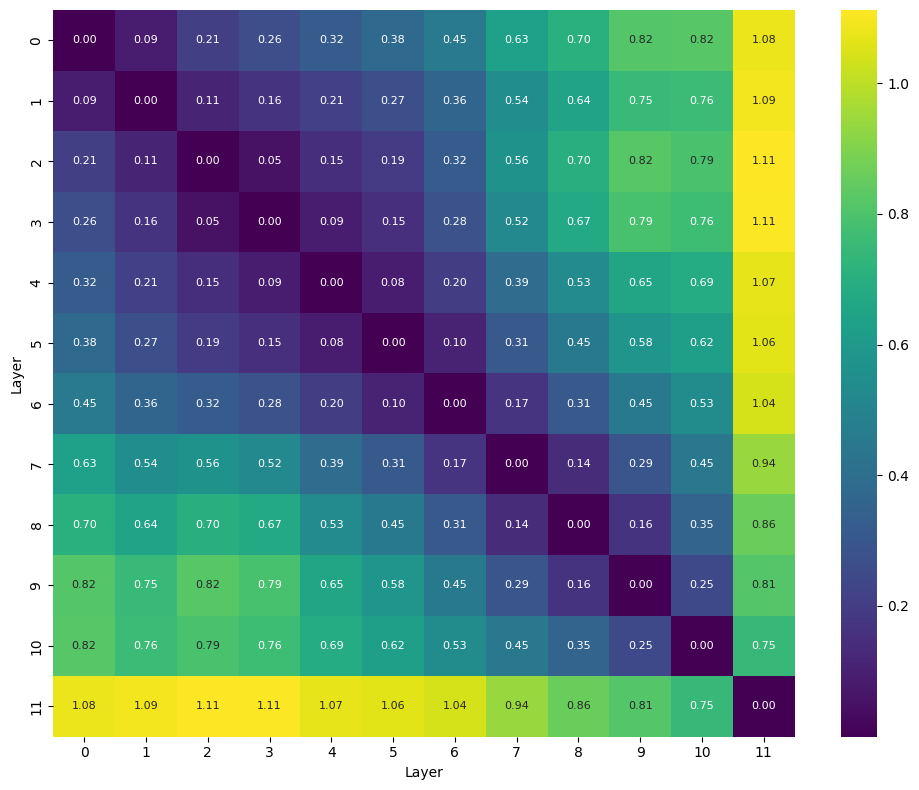

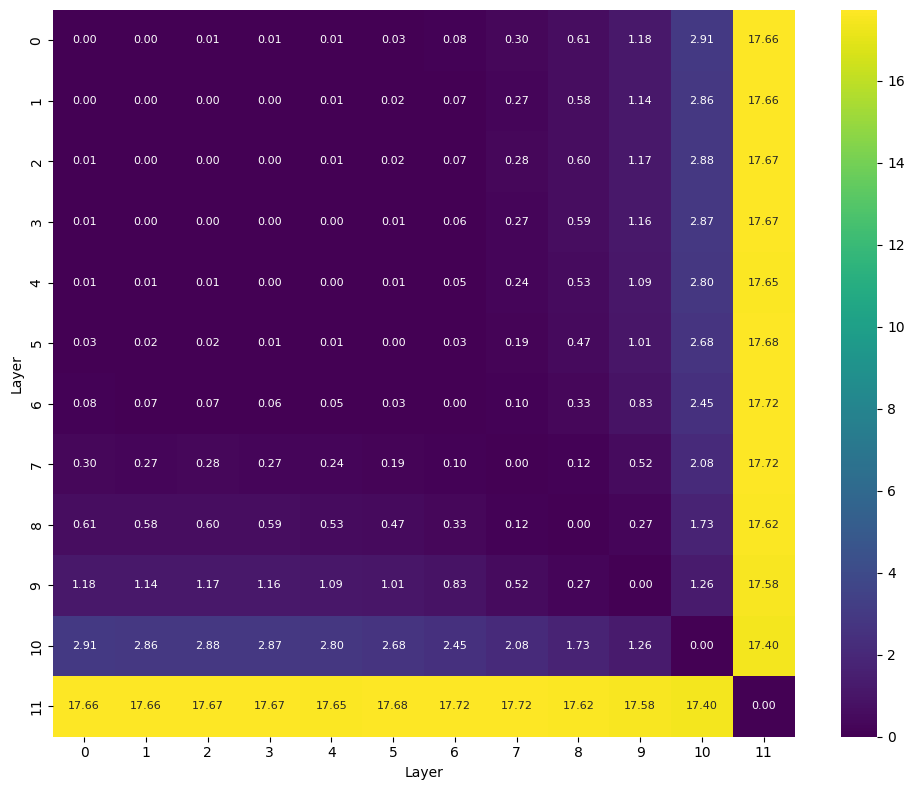

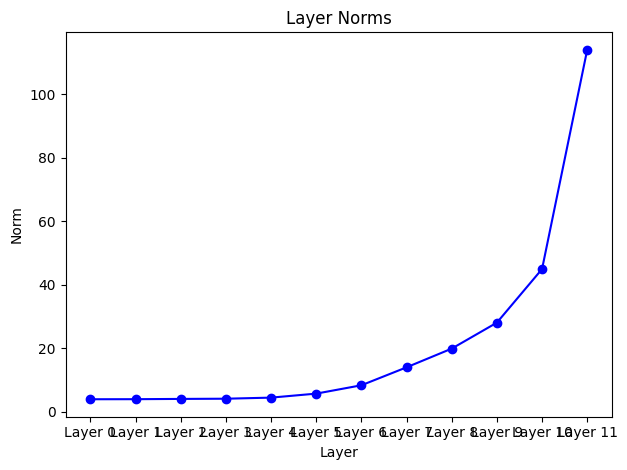

In [6]:
print(stable_rank(losses_cosine), stable_rank(losses_mse))
print(blockiness_var_explained(losses_cosine, K_max=2, penalty="bic")[0])
print(blockiness_var_explained(losses_mse, K_max=2, penalty="bic")[0])
print(norms)
fig = layer_iter_heatmap(losses_cosine, mask=None, figsize=(10, 8), cmap='viridis', vmin=None, vmax=None, fmt="0.2f", annot_kws={"size": 8})
fig = layer_iter_heatmap(losses_mse, mask=None, figsize=(10, 8), cmap='viridis', vmin=None, vmax=None, fmt="0.2f", annot_kws={"size": 8})
plot_norms(norms)

# 2
## Block 0: [1 2 3 4 5 6 7]
## Block 1: [ 8  9 10 11 12]

In [16]:
total_W = losses_cosine.sum() / 2            # undirected graph
eps = 0.2 * total_W 
blocks = recursive_max_cut(losses_cosine, eps=eps, min_size=2, solver='bruteforce')
for k, b in enumerate(blocks):
    print(f"Block {k}: {b + 1}")

Block 0: [1 2 3 4 5 6 7]
Block 1: [ 8  9 10 11 12]


# 3
## Block 0: [1 2 3 4 5 6 7]
## Block 1: [ 8  9 10]
## Block 2: [11 12]

In [17]:
total_W = losses_cosine.sum() / 2            # undirected graph
eps = 0.10 * total_W 
blocks = recursive_max_cut(losses_cosine, eps=eps, min_size=2, solver='bruteforce')
for k, b in enumerate(blocks):
    print(f"Block {k}: {b + 1}")

Block 0: [1 2 3 4 5 6 7]
Block 1: [ 8  9 10]
Block 2: [11 12]


# 4
## Block 0: [1 2 3 4]
## Block 1: [ 8  9 10]
## Block 2: [5 6 7]
## Block 3: [11 12]

In [18]:
total_W = losses_cosine.sum() / 2            # undirected graph
eps = 0.09 * total_W 
blocks = recursive_max_cut(losses_cosine, eps=eps, min_size=2, solver='bruteforce')
for k, b in enumerate(blocks):
    print(f"Block {k}: {b + 1}")

Block 0: [1 2 3 4]
Block 1: [ 8  9 10]
Block 2: [5 6 7]
Block 3: [11 12]
